In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

In [2]:
billboard_hot_100.dtypes
plt.rcParams.update({'font.size': 15})

In [3]:
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
from datetime import timedelta

grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)


In [5]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

## Position difference distributions

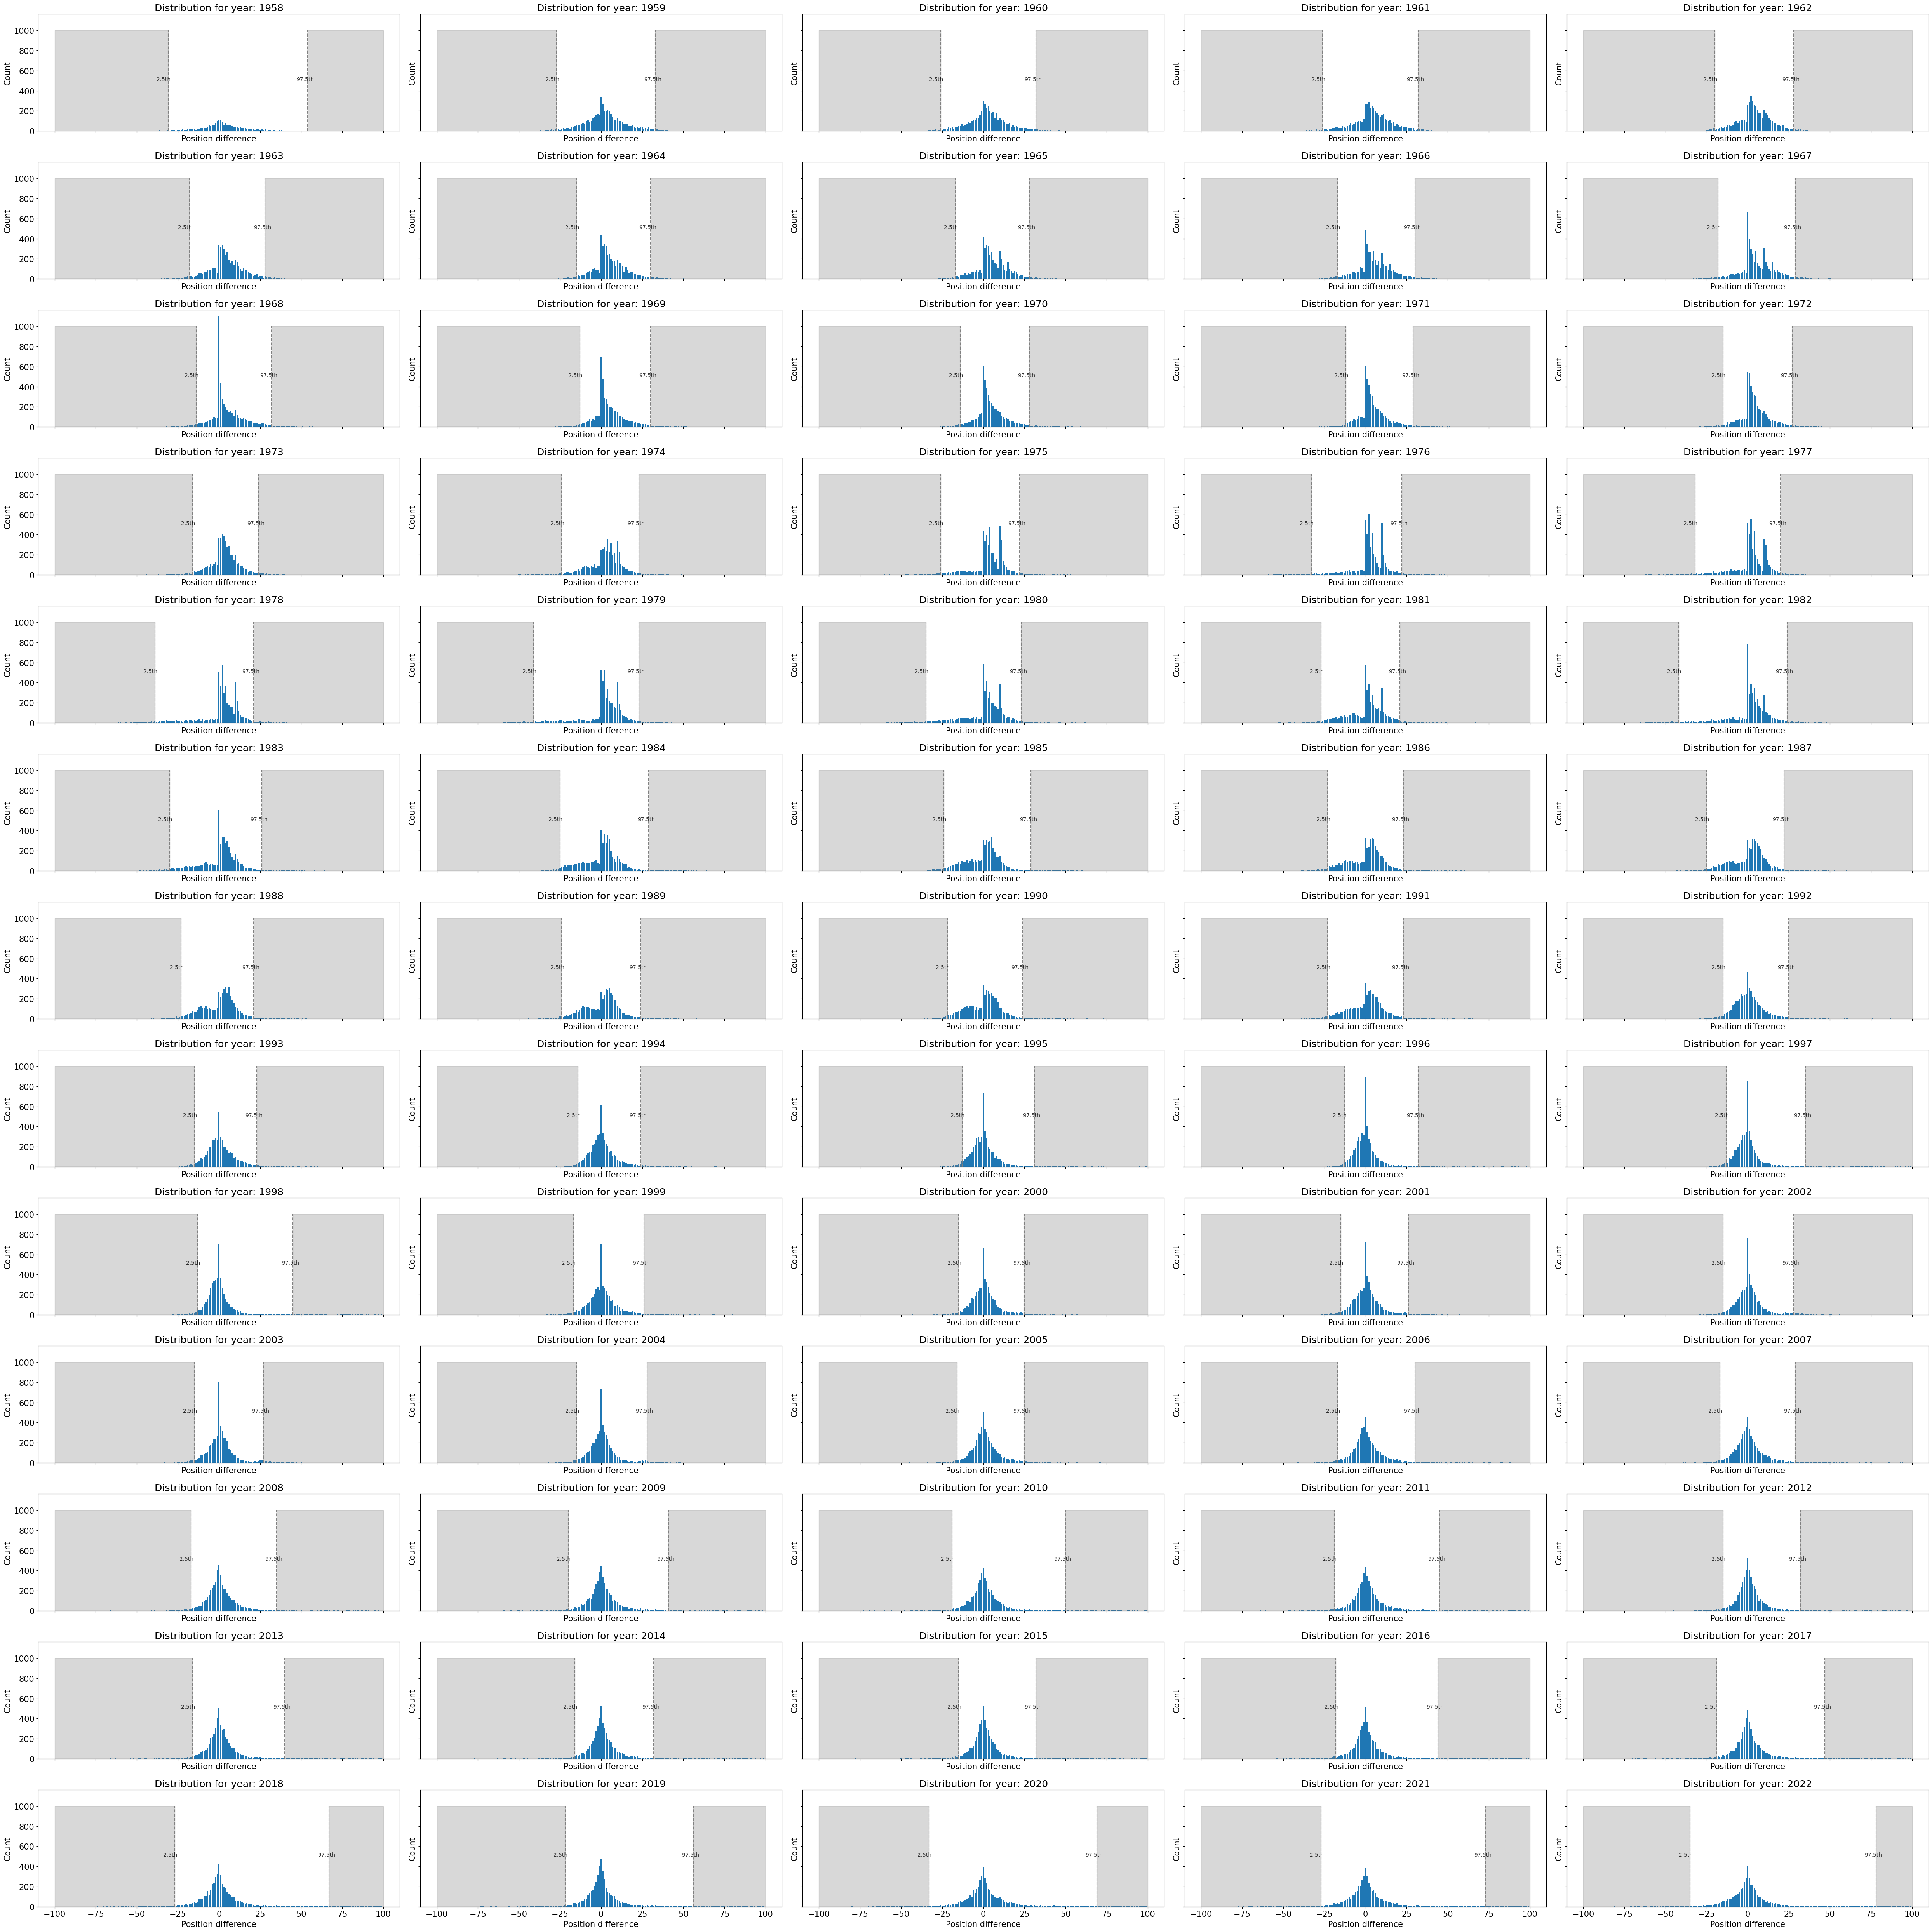

In [47]:
fig, axes = plt.subplots(13, 5, figsize=(50, 50), sharex=True, sharey=True)

row = 0
col = 0

distributions = {}

billboard_subset = billboard_hot_100_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1958, 2023):
    count_changes = billboard_subset[billboard_subset["year"] == year]["position_change"].value_counts().sort_index()
    # save normalized distribution
    distributions[year] = count_changes / count_changes.sum()
    axes[row, col].bar(count_changes.index, count_changes.values)
    perecentile_25 = billboard_subset[billboard_subset["year"] == year]["position_change"].quantile(0.025)
    perecentile_975 = billboard_subset[billboard_subset["year"] == year]["position_change"].quantile(0.975)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=1000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=1000, color="grey", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 1000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 500, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 1000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 500, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].set_title(f"Distribution for year: {year}")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 5:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
plt.tight_layout()
plt.savefig("figures/position_difference_distribution_percentiles.pdf", format="pdf")
plt.show()

## Distances between probability distributions

### Calculating the Bhattacharyya distance between each pair of distributions https://en.wikipedia.org/wiki/Bhattacharyya_distance

In [7]:
def bhattacharyya_distance(distribution1, distribution2):
    return -math.log(sum(math.sqrt(x * y) for x, y in zip(distribution1, distribution2)))

In [8]:
distances_bhattacharyya = {}

for year_1 in range(1958, 2023):
    for year_2 in range(1958, 2023):
        if year_1 not in distances_bhattacharyya:
            distances_bhattacharyya[year_1] = {}
        distances_bhattacharyya[year_1][year_2] = bhattacharyya_distance(
            distributions[year_1].values, distributions[year_2].values)

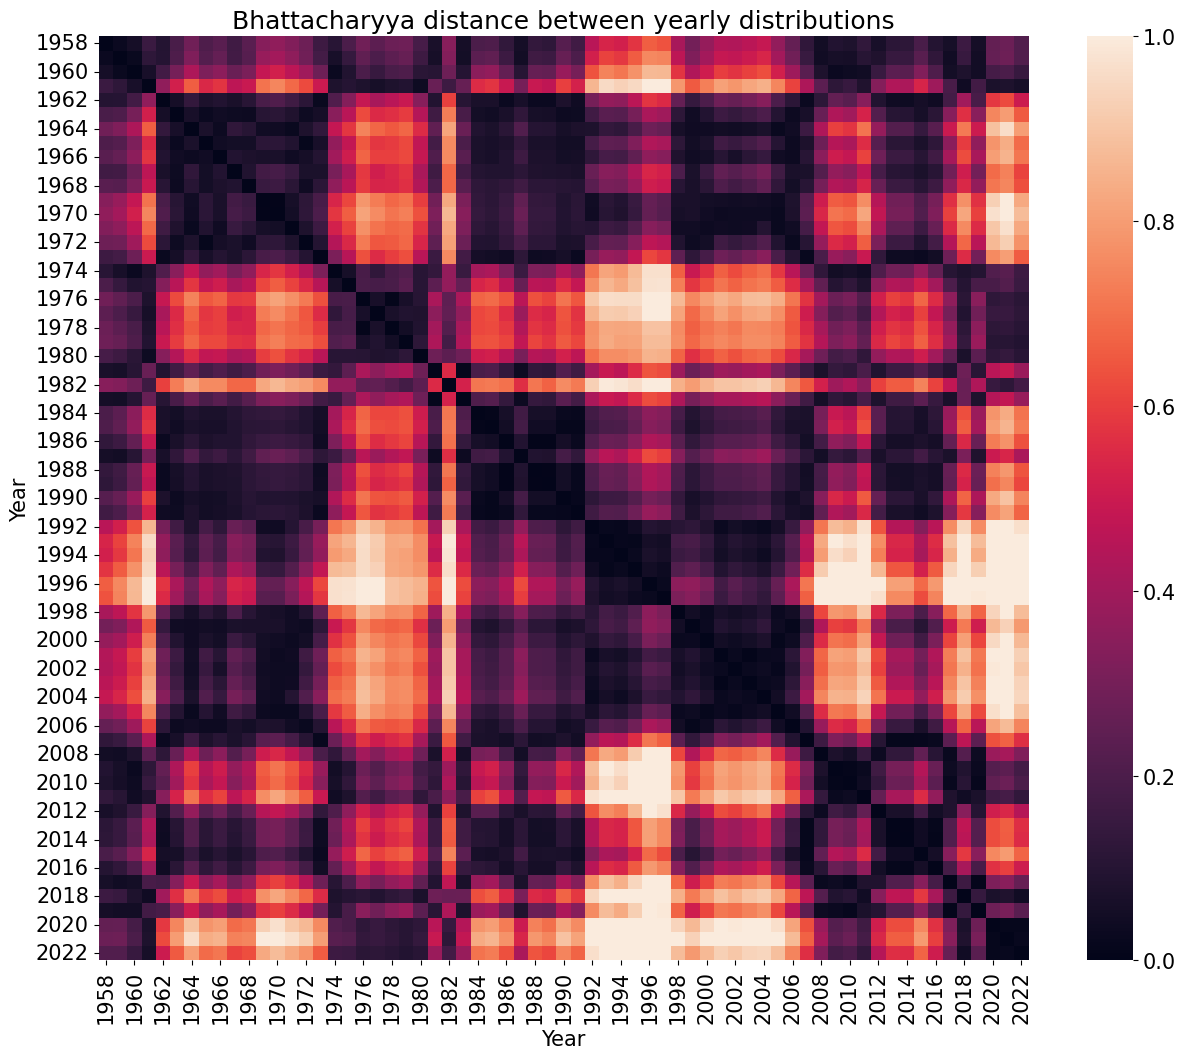

In [9]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(pd.DataFrame.from_dict(distances_bhattacharyya), ax=ax, vmax=1)
ax.set_title("Bhattacharyya distance between yearly distributions")
ax.set_xlabel("Year")
ax.set_ylabel("Year")

plt.savefig("figures/distances_distributions_bhattacharyya.pdf", format="pdf")
plt.show()

### Calculating the Kullback–Leibler divergence between each pair of distributions https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

In [10]:
def kullback_leibler_distance(distribution1, distribution2):
    return sum(x * math.log(x / y) for x, y in zip(distribution1, distribution2))

In [11]:
# can be construed as measuring the expected number of extra bits
# required to code samples from P using a code optimized for Q rather than the
# code optimized for P

In [12]:
distances_kullback = {}

for year_1 in range(1958, 2023):
    for year_2 in range(1958, 2023):
        if year_1 not in distances_kullback:
            distances_kullback[year_1] = {}
        distances_kullback[year_1][year_2] = kullback_leibler_distance(
            distributions[year_1].values, distributions[year_2].values)

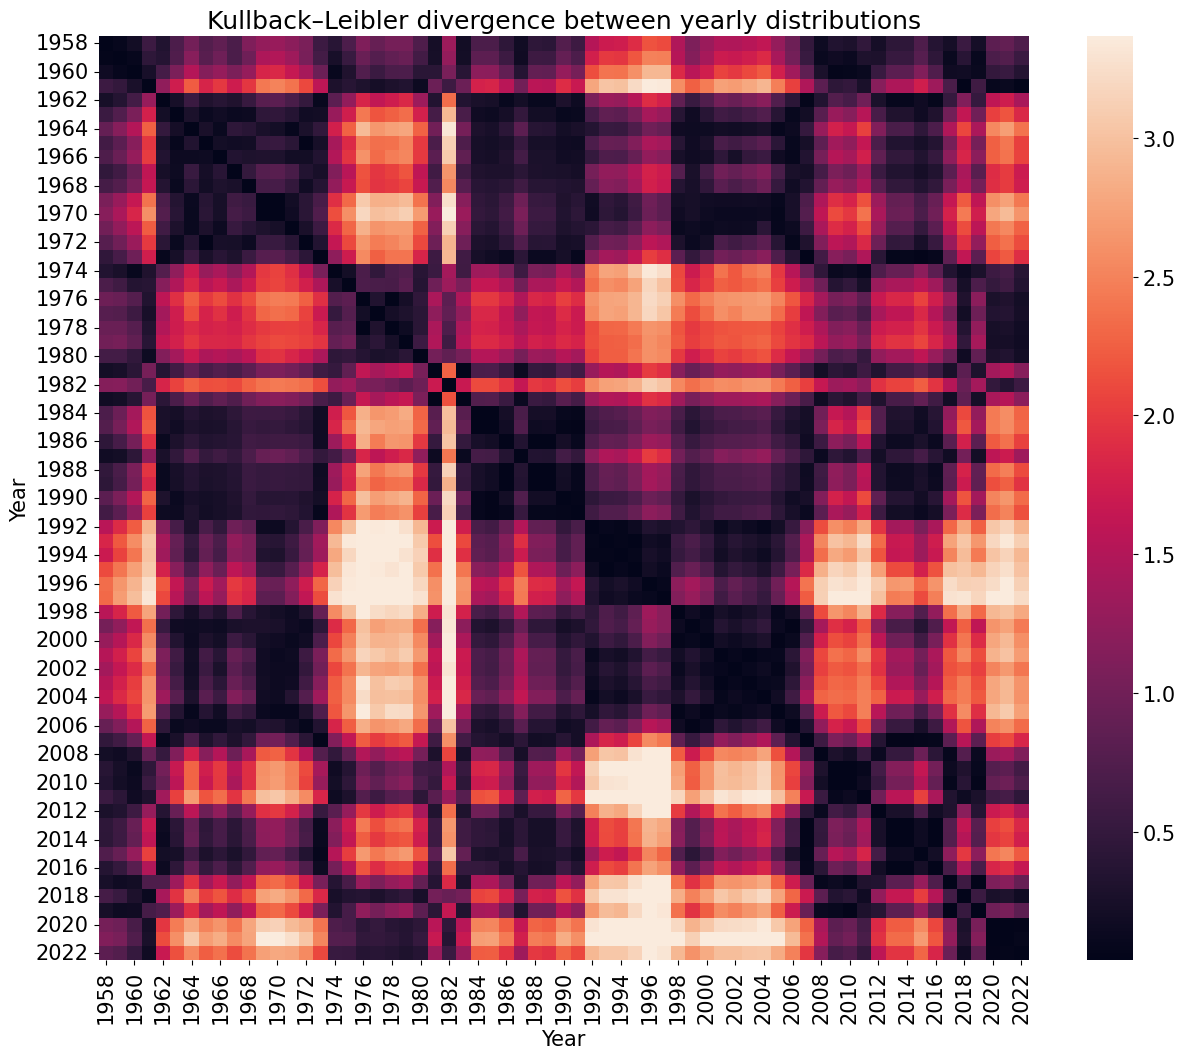

In [13]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.heatmap(pd.DataFrame.from_dict(distances_kullback), ax=ax, robust=True)
ax.set_title("Kullback–Leibler divergence between yearly distributions")
ax.set_xlabel("Year")
ax.set_ylabel("Year")

plt.savefig("figures/distances_distributions_kullback.pdf", format="pdf")
plt.show()